In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.cuda.is_available()

True

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import random

class ArrowsDataset(Dataset):
    def __init__(self, path=None ,transform=None, train=True):
        super().__init__()
        
        
        
        self.transform = transform
        self.train = train
        
        self.images = []
       
        
        self.clases = ['PLUS', 'MINUS']
        
        for clas in self.clases:
            class_path = os.path.join(path, clas)
            images_paths = os.listdir(class_path)
            
            
            
            for i in images_paths:
                self.images.append((os.path.join(class_path, i),self.clases.index(clas)))
                
        
        random.shuffle(self.images)
                
                
        if self.train:
            self.images = self.images[:int(len(self.images) * 0.8)]
            
        else:
            self.images = self.images[int(len(self.images) * 0.8):]
            

        
            
            
        
            
        
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx][0]).convert('RGB')
        
        if random.random() > 0.1:
            image = transforms.functional.hflip(image)
        
        label = self.images[idx][1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((128, 128)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 4

trainset = ArrowsDataset(path='./plus_minus_dataset', transform=transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = ArrowsDataset(path='./plus_minus_dataset', transform=transform, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)



classes = ('PLUS', 'MINUS')
device

Let us show some of the training images, for fun.



c:\Users\emerg\Desktop\Python\Circuit-Simulator-And-Reduction\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


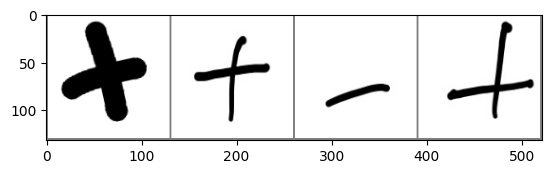

PLUS  PLUS  MINUS PLUS 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        
        # image is 128x128x3
        # after 1st conv: (128-5+1)/1 = 124x124x6
        # after 1st pooling: 62x62x6
        self.conv1 = nn.Conv2d(3, 6, 5)
        # after 2nd conv: (62-5+1)/1 = 58x58x16
        # after 2nd pooling: 29x29x16
        self.conv2 = nn.Conv2d(6, 16, 5)
        # after 1st fc: 16*29*29 = 13456
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        
        
        
        
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

criterion.to(device)


CrossEntropyLoss()

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1} loss: {running_loss / len(trainloader)}')
    running_loss = 0.0

print('\nFinished Training')

Epoch 1 loss: 0.11780137782987425
Epoch 2 loss: 0.008430458190464596
Epoch 3 loss: 0.011618784645140061
Epoch 4 loss: 0.002220429397227438
Epoch 5 loss: 0.0011634922792988765
Epoch 6 loss: 0.00107625707466412
Epoch 7 loss: 0.001027384482746348
Epoch 8 loss: 0.000991011333313935
Epoch 9 loss: 0.0009591044595349342
Epoch 10 loss: 0.0009282755377432733

Finished Training


Let's quickly save our trained model:



In [9]:
PATH = './plus_minus_classifier.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



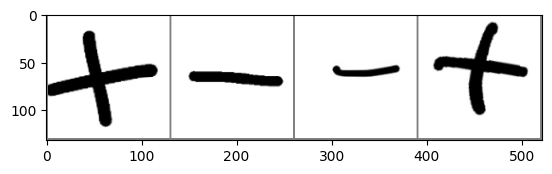

GroundTruth:  PLUS  MINUS MINUS PLUS 


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  PLUS  MINUS MINUS PLUS 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)} test images: {100 * correct // total} %')

Accuracy of the network on the 435 test images: 99 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: PLUS  is 100.0 %
Accuracy for class: MINUS is 99.9 %


In [22]:
# inference on a single image

img = Image.open(r"symbol1_temp.png").convert('RGB')
img = img.rotate(90)
img = transform(img)
img = img.unsqueeze(0)
# img = img.to(device)

outputs = net(img)
_, predicted = torch.max(outputs, 1)

print(f'Predicted: {classes[predicted[0]]}')

Predicted: PLUS


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [18]:
del dataiter